# **Task 2**

---

## **Buidling a Machine Learning Model**

This task involves choosing an appropriate algorithm, training the model, and evaluating its performance. The goal is to create a model that can be easily understood and acted on by business stakeholders. 

The challenge lies in selecting the right machine learning algorithm and fine-tuning it to accurately predict which customers are at risk of leaving. This model will provide actionable insights, enabling the team to develop targeted interventions to retain valuable customers. Specifically, it is important to select the most appropriate machine learning algorithm, which balances predictive accuracy with interpretability

### **Data Preparation**


First, we must load the processed data from Task 1 and resample them with `SMOTE` method to tackle the **class imbalance** issue.

In [1]:
# Import data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load processed data
df = pd.read_csv("Data/processed_churn_csv")

Let's have a look at the current processed data: 

In [3]:
df.head()

,Age,TotalSpent,AvgSpent,NumTransactions,UniqueTransactions,ServiceInteractions,ResolutionRate,LoginFrequency,ChurnStatus,DaysSinceLastLogin,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Online Banking,ServiceUsage_Website,AgeGroup_<30,AgeGroup_>50
0,1.229628,-1.159172,2.134218,-1.557954,-1.557954,-0.002451,1.524083,0.575702,0,-1.021557,True,False,True,False,True,False,False,False,False,True
1,1.426547,0.386676,-0.353258,0.747849,0.747849,-0.002451,1.524083,-1.488513,1,-1.450763,True,True,False,False,True,False,False,True,False,True
2,-1.658518,0.599310,0.445651,0.363548,0.363548,-0.002451,1.524083,-1.630872,0,-1.260005,True,False,True,False,True,False,False,True,True,False
3,-1.461599,-0.474645,-0.831840,-0.020752,-0.020752,1.222911,0.347185,-1.702052,0,-0.477897,True,False,False,True,True,False,False,True,True,False
4,-1.461599,1.007342,0.017448,1.132149,1.132149,-1.227812,-0.829713,1.073961,0,-1.078785,True,False,False,False,False,True,False,True,True,False


We create different subsets to hold the predictive and target variable:

In [4]:
# Define model variables
X = df.drop(columns=["ChurnStatus"])
y = df["ChurnStatus"]

Apply `train_test_split` to split variables' arrays into random train and test subsets: 

In [5]:
# Split train, test sets for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

To handle **class imbalance** issue based on low number of churners (**only ~ 20% of the dataset**), we use **_SMOTE_** (Synthetic Minority Oversampling Technique) to boost the minority class in training set only.

In [6]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### **Crafting the Predictive Blueprint** 

The idea is to iterate on various models, tuning hyperparameters, and validating the model to ensure it generalises well to new data; therefore, we will train a collection of models to assess their overall performance.

For this project, we choose **Logistic Regression**, **Random Forest**, **XGBoost**. **Decision Tree** and **Neural Network** to train the processed data with a predefined grid of parameters.

In [7]:
# Define models and parameter grids
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear']
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    },
    "Decision Tree": {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    "Neural Network": {
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001]
    }
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42)
}

Now we can fit these models with the resampled data, then evaluate their performance via confusion matrix and metrics such as precision score, recall and F1 score.

In [15]:
# Grid search and evaluation
best_models = {}
importances = {}

# Initialize summary storage
evaluation_summary = []

for name, model in models.items():
    print(f"\nTuning and evaluating {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1, error_score='raise')
    try:
        # fix column names for XGBoost
        X_resampled.columns = X_resampled.columns.str.replace(r"[\[\]<>]", "", regex=True)
        X_test.columns = X_test.columns.str.replace(r"[\[\]<>]", "", regex=True)

        # Train all models
        grid.fit(X_resampled, y_resampled)
        best_models[name] = grid.best_estimator_
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1] if hasattr(grid, "predict_proba") else None

        # Calculate evaluation metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        evaluation_summary.append({
            "Model": name,
            "Best Params": grid.best_params_,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC-AUC": roc_auc
        })

        if y_proba is not None:
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        # Feature importance (if available)
        if hasattr(grid.best_estimator_, 'feature_importances_'):
            importances[name] = grid.best_estimator_.feature_importances_

    except Exception as e:
        print(f"Model {name} failed during GridSearchCV: {e}")


Tuning and evaluating Logistic Regression...

Tuning and evaluating Random Forest...

Tuning and evaluating XGBoost...

Tuning and evaluating Decision Tree...

Tuning and evaluating Neural Network...


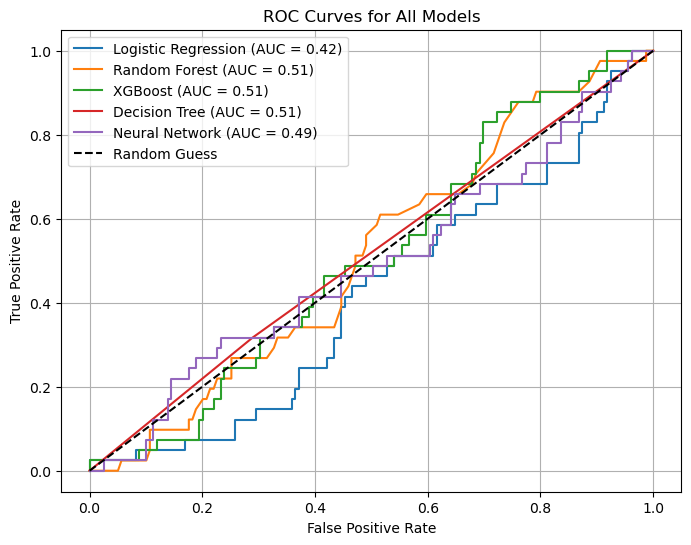

In [16]:
# Show all ROC curves in one plot
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Summarize evaluation metrics
summary_df = pd.DataFrame(evaluation_summary)
summary_df.set_index("Model", inplace=True)
print(summary_df.round(2))

                                                           Best Params  \
Model                                                                    
Logistic Regression                  {'C': 0.1, 'solver': 'liblinear'}   
Random Forest        {'max_depth': None, 'min_samples_split': 2, 'n...   
XGBoost              {'learning_rate': 0.05, 'max_depth': 5, 'n_est...   
Decision Tree              {'max_depth': None, 'min_samples_split': 2}   
Neural Network       {'activation': 'relu', 'alpha': 0.001, 'hidden...   

                     Precision  Recall  F1 Score  ROC-AUC  
Model                                                      
Logistic Regression       0.16    0.32      0.21     0.42  
Random Forest             0.13    0.10      0.11     0.51  
XGBoost                   0.09    0.07      0.08     0.51  
Decision Tree             0.22    0.32      0.26     0.51  
Neural Network            0.23    0.27      0.25     0.49  


**Interpretation:**

- `Logistic Regression` has a slightly better recall than other models, making it marginally more helpful for flagging potential churners.

- `Random Forest` prioritizes accuracy on the majority class but fails to capture churners effectively despite high overall accuracy (**69%**).

- `XGBoost` performs worst among the three in identifying churners, possibly over-regularized or constrained by hyperparameters.